In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy.spatial.distance import cdist
import os
import glob

df=pd.read_csv('geolife_trajectories_cleaned.csv')
df_red=df.sample(frac=0.01) # Corrected 'samples' to 'sample'
data=df_red[['latitude', 'longitude']].values
print(len(data))

5314


In [57]:
n_clusters=10
methods=['kmeans', 'dbscan', 'hierarchical']
results={}
X=data
for method in methods:
  if method=='kmeans':
    model=KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels=model.fit_predict(X)  # Fit and predict to get labels

  elif method=='dbscan':
    model=DBSCAN(eps=0.01, min_samples=10)
    labels=model.fit_predict(data)

  elif method=='hierarchical':
    model=AgglomerativeClustering(n_clusters=n_clusters)
    labels=model.fit_predict(data)

  if len(set(labels)) > 1:  # Need at least 2 clusters for metrics
                silhouette = silhouette_score(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels)
                calinski = calinski_harabasz_score(X, labels)
  else:
    silhouette = davies_bouldin = calinski = np.nan

  results[method] = {
                'labels': labels,
                'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
                'silhouette_score': silhouette,
                'davies_bouldin_score': davies_bouldin,
                'calinski_harabasz_score': calinski
            }

  print(f"Number of clusters: {results[method]['n_clusters']}")
  print(f"Silhouette Score: {silhouette:.3f}")
  print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
  print(f"Calinski-Harabasz Score: {calinski:.1f}")

Number of clusters: 10
Silhouette Score: 0.813
Davies-Bouldin Score: 0.417
Calinski-Harabasz Score: 57904.2
Number of clusters: 39
Silhouette Score: -0.086
Davies-Bouldin Score: 1.808
Calinski-Harabasz Score: 108.6
Number of clusters: 10
Silhouette Score: 0.810
Davies-Bouldin Score: 0.466
Calinski-Harabasz Score: 54652.5


In [58]:
waypoints = []
methods=['centroid', 'medoid']
method=methods[0]

unique_labels = set(labels)
if -1 in unique_labels:  # Remove noise label from DBSCAN
  unique_labels.remove(-1)

for label in unique_labels:
  cluster_points = data[labels == label]
  waypoint = None  # Initialize waypoint

  if method == 'centroid':
    waypoint = cluster_points.mean(axis=0)
  elif method == 'medoid':
    center = cluster_points.mean(axis=0)
    distances = cdist([center], cluster_points)[0]
    medoid_idx = np.argmin(distances)
    waypoint = cluster_points[medoid_idx]

  if waypoint is not None: # Only append if a waypoint was determined
    waypoints.append(waypoint)

np.array(waypoints)

array([[ 22.96278224, 114.89514378],
       [ 30.09362262, 119.85963253],
       [ 39.95280618, 116.38690384],
       [ 39.76354252, 118.48253246],
       [ 41.75500649, 125.97239992],
       [ 45.0039966 , 127.75953255],
       [ 33.2187507 , 116.36334338],
       [ 37.76917613, 115.86721435],
       [ 46.61560823, 124.94066597],
       [ 40.97320009, 117.52094177]])

In [59]:
n=len(waypoints)
G=nx.Graph()

for i,wp in enumerate(waypoints):
  G.add_node(i, pos=wp)

for i in range(n):
  for j in range(i+1,n):
    dist = np.linalg.norm(waypoints[i] - waypoints[j])
    G.add_edge(i,j, weight=dist)
graph=G
print(f"Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph created: 10 nodes, 45 edges


In [60]:
start_node=0
algo=['tsp_approx', 'shortest_path_tree', 'dijkstra']
for alg in algo:
  if alg=='tsp_approx':
    path=nx.approximation.traveling_salesman_problem(graph, cycle=True, method=nx.approximation.christofides)
  elif alg=='shortest_path_tree':
    mst=nx.minimum_spanning_tree(graph)
    path=list(nx.dfs_preorder_nodes(mst, source=start_node))
  elif alg=='dijkstra':
    lengths=nx.single_source_dijkstra_path_length(graph,start_node)
    farthest=max(lengths, key=lengths.get)
    path_to=nx.dijkstra_path(graph, start_node, farthest)
    path_back=nx.dijkstra_path(graph, farthest, start_node)
    path=path_to+path_back[1:]

  total_distance = sum(
            graph[path[i]][path[i+1]]['weight']
            for i in range(len(path)-1)
        )

  print(f"\nPath planning with {alg}:")
  print(f"Path length: {len(path)} waypoints")
  print(f"Total distance: {total_distance:.4f}")


Path planning with tsp_approx:
Path length: 11 waypoints
Total distance: 63.6739

Path planning with shortest_path_tree:
Path length: 10 waypoints
Total distance: 37.9762

Path planning with dijkstra:
Path length: 3 waypoints
Total distance: 51.3953


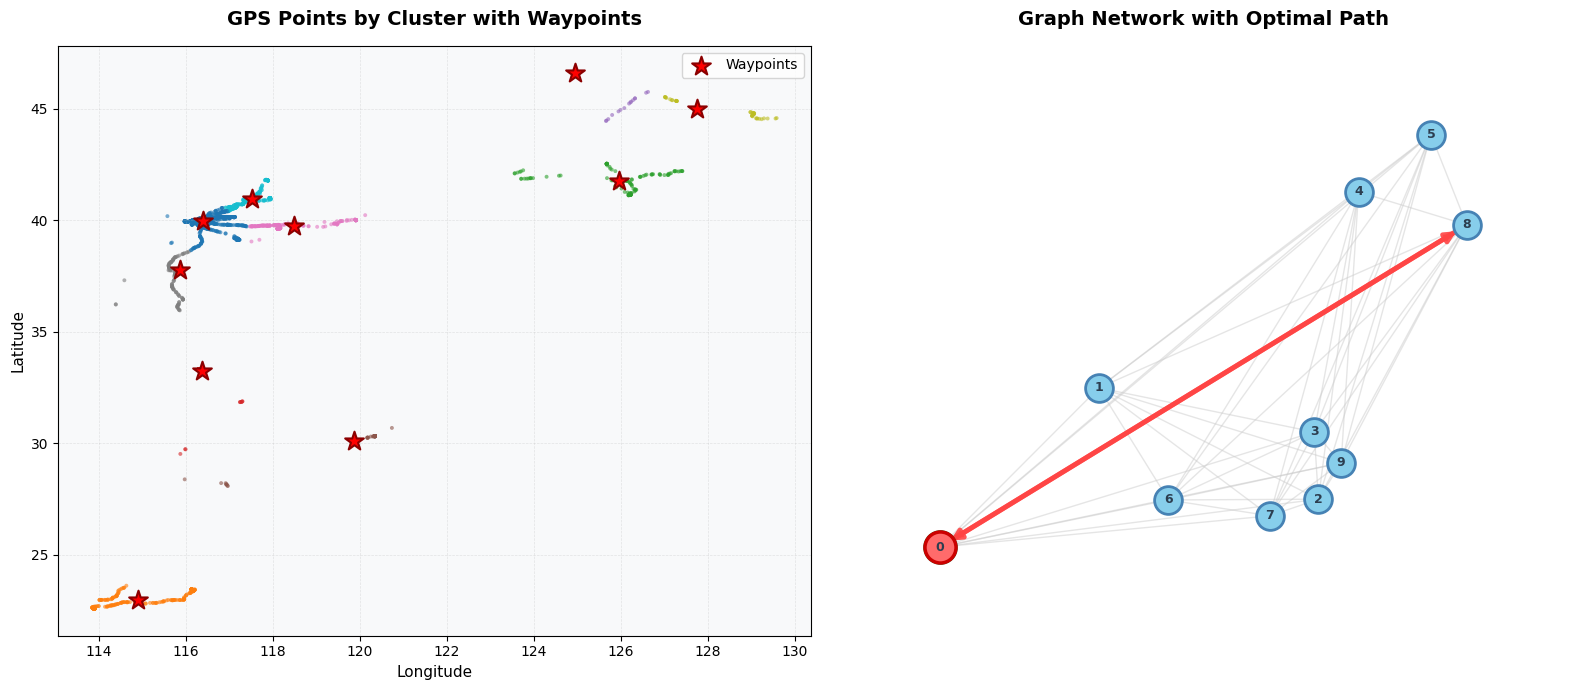

In [61]:
# Create the left plot: GPS points colored by cluster with waypoint stars
fig = plt.figure(figsize=(16, 7))

# Left plot: GPS clusters and waypoints
ax1 = plt.subplot(1, 2, 1)
scatter = ax1.scatter(data[:, 1], data[:, 0],
                      c=results['kmeans']['labels'],
                      cmap='tab10',
                      s=8,
                      alpha=0.6,
                      edgecolors='none')
waypoints_array = np.array(waypoints)
ax1.scatter(waypoints_array[:, 1], waypoints_array[:, 0],
           c='red',
           s=200,
           marker='*',
           label='Waypoints',
           edgecolors='darkred',
           linewidths=1.5,
           zorder=5)
ax1.set_title('GPS Points by Cluster with Waypoints', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Longitude', fontsize=11)
ax1.set_ylabel('Latitude', fontsize=11)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_facecolor('#f8f9fa')

# Right plot: Graph network and optimal path
ax2 = plt.subplot(1, 2, 2)
pos = nx.get_node_attributes(graph, 'pos')

# Draw all edges with light gray color
nx.draw_networkx_edges(graph, pos,
                       edge_color='#cccccc',
                       width=1,
                       alpha=0.5,
                       ax=ax2)

# Draw the optimal path with prominent styling
if path:
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(graph, pos,
                          edgelist=path_edges,
                          edge_color='#ff4444',
                          width=3.5,
                          alpha=0.9,
                          arrows=True,
                          arrowstyle='-|>',
                          arrowsize=15,
                          ax=ax2)

    # Draw all nodes
    nx.draw_networkx_nodes(graph, pos,
                          node_color='#87ceeb',
                          node_size=400,
                          edgecolors='#4682b4',
                          linewidths=2,
                          ax=ax2)

    # Highlight the start node
    nx.draw_networkx_nodes(graph, pos,
                          nodelist=[start_node],
                          node_color='#00cc66',
                          node_size=500,
                          edgecolors='#008844',
                          linewidths=2.5,
                          ax=ax2)

    # Highlight the end node
    if len(path) > 1:
        nx.draw_networkx_nodes(graph, pos,
                              nodelist=[path[-1]],
                              node_color='#ff6b6b',
                              node_size=500,
                              edgecolors='#cc0000',
                              linewidths=2.5,
                              ax=ax2)
else:
    # If no path, just draw nodes normally
    nx.draw_networkx_nodes(graph, pos,
                          node_color='#87ceeb',
                          node_size=400,
                          edgecolors='#4682b4',
                          linewidths=2,
                          ax=ax2)

# Draw labels with better visibility
nx.draw_networkx_labels(graph, pos,
                       font_size=9,
                       font_weight='bold',
                       font_color='#2c3e50',
                       ax=ax2)

ax2.set_title('Graph Network with Optimal Path', fontsize=14, fontweight='bold', pad=15)
ax2.set_facecolor('#f8f9fa')
ax2.margins(0.15)  # Add some padding around the graph
ax2.axis('off')  # Remove axis for cleaner look

plt.tight_layout()
plt.show()

Clustering Algorithm Comparison Table:


,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
kmeans,10,0.812569,0.416932,57904.238322
dbscan,39,-0.086268,1.808314,108.582166
hierarchical,10,0.809871,0.465693,54652.497187


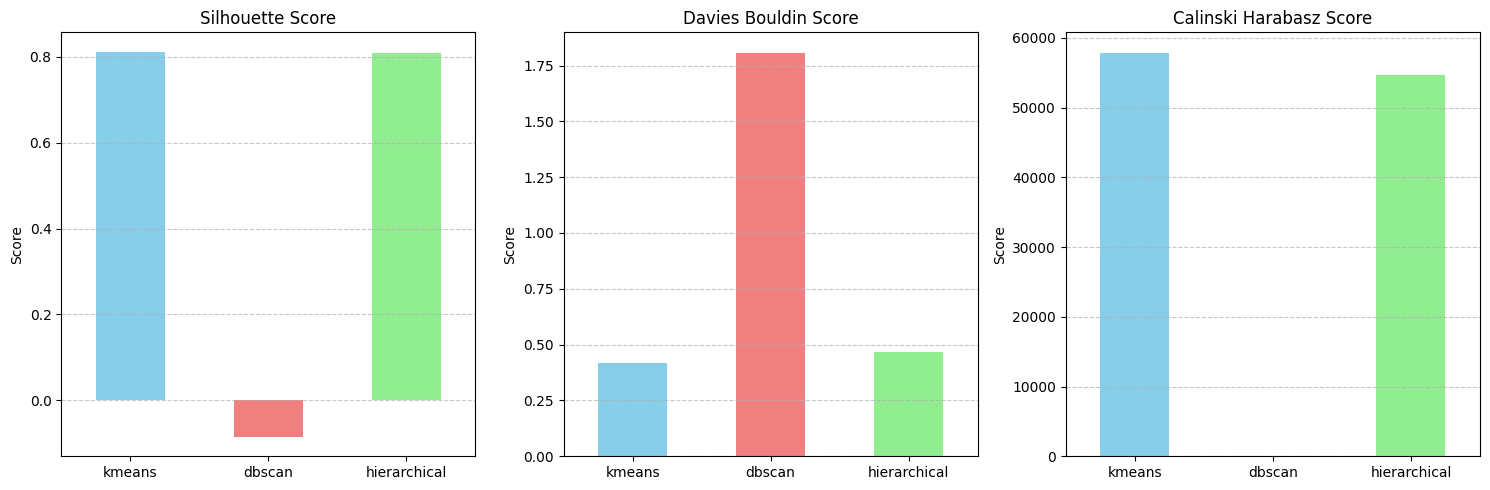

In [62]:
# Create a comparison table
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.drop('labels', axis=1) # Remove the 'labels' column as it's not easily displayed in a table
print("Clustering Algorithm Comparison Table:")
display(results_df)

# Create bar charts for comparison metrics
metrics = ['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']

fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for i, metric in enumerate(metrics):
    ax = axes[i]
    results_df[metric].plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()